In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import optimize

sns.set()

In [2]:
from src.Python.ICGC_data_parser import SSM_Reader

In [3]:
from collections import Counter

def recurrence_data(mutation, parser):
    "Fetch the recurrence data for a given mutation."
    recurrence_by_project = {occ.project_code:{'affected_donors': occ.affected_donors,
                                               'tested_donors': occ.tested_donors} 
                                     for occ in parser(mutation)}
    return {'mutation_id' : mutation.ID,
            'proj_recurrence' : recurrence_by_project,
            'total_affected_donors': mutation.INFO['affected_donors'],
            'total_tested_donors': mutation.INFO['tested_donors']}
# ---


def recurrence_distribution(filename, project=None, filters=None):
    """Searches through input file for mutations related to 
    the given cancer project.

    Gets the mutation recurrence distribution for the data 
    (i.e. how many mutations are repeated in ``n`` different 
    patients?)
    """
    if filters is None:
        filters = []
    
    # Open mutations file
    reader = SSM_Reader(filename=filename)
    OCCURRENCES = reader.subfield_parser('OCCURRENCE')

    # Initialize distribution
    tested_donors = None
    distribution = Counter()

    for record in reader.parse(filters=[project]+filters):
        recurrence = recurrence_data(record, OCCURRENCES)

        if project: # When a project is specified
            proj_recurrence = recurrence['proj_recurrence'][project]
            proj_affected = proj_recurrence['affected_donors']
            distribution[int(proj_affected)] += 1

            if tested_donors is None:
                tested_donors = proj_recurrence['tested_donors']
                
        else: # When all projects are parsed
            total_affected = recurrence['total_affected_donors']
            distribution[int(total_affected)] += 1

            if tested_donors is None:
                tested_donors = recurrence['total_tested_donors']
                
    return distribution, tested_donors
# ---

distribution, tested_donors = recurrence_distribution('data/data-release-25/ssm_sample.vcf')

In [4]:
for i in sorted(distribution.keys()):
    print(i, distribution[i])
print(tested_donors)

1 295368
2 17083
3 2809
4 910
5 458
6 197
7 119
8 61
9 41
10 20
11 17
12 17
13 8
14 7
15 5
16 3
17 2
18 5
19 1
20 1
21 1
22 1
24 1
12198


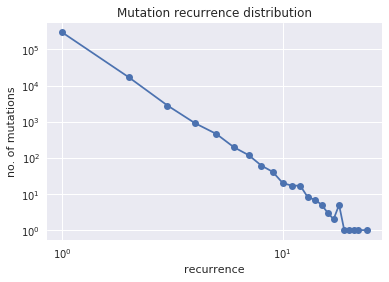

In [6]:
x = sorted(distribution.keys())
y = [distribution[i] for i in x]

plt.plot(x, y, marker='o')
plt.yscale('log')
plt.xscale('log')
plt.title('Mutation recurrence distribution')
plt.xlabel('recurrence')
plt.ylabel('no. of mutations')
plt.show()

In [18]:
xdata = np.array(x)
ydata = np.array(y)
yerr = 0.2 * ydata

[ 5.45859004 -4.07123806]
[[ 0.01509406 -0.01369372]
 [-0.01369372  0.01404109]]


(1.0, 11)

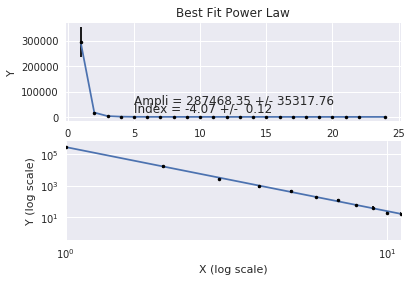

In [19]:
##########
# Fitting the data -- Least Squares Method
##########

# Power-law fitting is best done by first converting
# to a linear equation and then fitting to a straight line.
# Note that the `logyerr` term here is ignoring a constant prefactor.
#
#  y = a * x^b
#  log(y) = log(a) + b*log(x)
#
# Define function for calculating a power law
powerlaw = lambda x, amp, index: amp * (x**index)

logx = np.log10(xdata)
logy = np.log10(ydata)
logyerr = yerr / ydata

# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * x
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

pinit = [1.0, -1.0]
out = optimize.leastsq(errfunc, pinit,
                       args=(logx, logy, logyerr), full_output=1)

pfinal = out[0]
covar = out[1]
print(pfinal)
print(covar)

index = pfinal[1]
amp = 10.0**pfinal[0]

indexErr = np.sqrt( covar[1][1] )
ampErr = np.sqrt( covar[0][0] ) * amp

##########
# Plotting data
##########

plt.clf()
plt.subplot(2, 1, 1)
plt.plot(xdata, powerlaw(xdata, amp, index))     # Fit
plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
plt.text(5, 50000, 'Ampli = %5.2f +/- %5.2f' % (amp, ampErr))
plt.text(5, 20000, 'Index = %5.2f +/- %5.2f' % (index, indexErr))
plt.title('Best Fit Power Law')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(2, 1, 2)
plt.loglog(xdata, powerlaw(xdata, amp, index))
plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
plt.xlabel('X (log scale)')
plt.ylabel('Y (log scale)')
plt.xlim(1.0, 11)